In [1]:
import os
import warnings
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import geopandas as gpd

import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.clip as cl
import earthpy as et

import common_functions as common
import naip_data_process as naip

# Turn off warnings so they don't clutter the notebook
warnings.filterwarnings("ignore")

# set working dir
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

### NAIP Processing
Some text here

In [2]:
# Open 2011 mosaic file
mosaic_2011_fp = "data/final-project/cottonwood-heights-utah/naip/outputs/naip_2011_mosaic_crop.tif"
with rio.open(mosaic_2011_fp) as mosaic_2011_src:
    mosaic_2011_scene = mosaic_2011_src.read()
    mosaic_2011_scene_meta = mosaic_2011_src.meta
    mosaic_2011_scene_bds = mosaic_2011_src.bounds
    study_area_box_reprojected = common.study_area_box_gdf.to_crs(mosaic_2011_src.crs)
    masked_mosaic_2011, masked_mosaic_2011_affine = mask(mosaic_2011_src, study_area_box_reprojected.geometry, crop=True)

In [3]:
# Open 2014 mosaic file
mosaic_2014_fp = "data/final-project/cottonwood-heights-utah/naip/outputs/naip_2014_mosaic_crop.tif"
with rio.open(mosaic_2014_fp) as mosaic_2014_src:
    mosaic_2014_scene = mosaic_2014_src.read()
    mosaic_2014_scene_meta = mosaic_2014_src.meta
    mosaic_2014_scene_bds = mosaic_2014_src.bounds
    study_area_box_reprojected = common.study_area_box_gdf.to_crs(mosaic_2014_src.crs)
    masked_mosaic_2014, masked_mosaic_2014_affine = mask(mosaic_2014_src, study_area_box_reprojected.geometry, crop=True)

In [4]:
# Convert the data to int to avoid the divide by zero error
mosaic_2011_scene = mosaic_2011_scene.astype(int)
mosaic_2014_scene = mosaic_2014_scene.astype(int)
# Compute NDVI
ndvi_2011_mosaic = es.normalized_diff(b2=mosaic_2011_scene[3], b1=mosaic_2011_scene[2])
ndvi_2014_mosaic = es.normalized_diff(b2=mosaic_2014_scene[3], b1=mosaic_2014_scene[2])

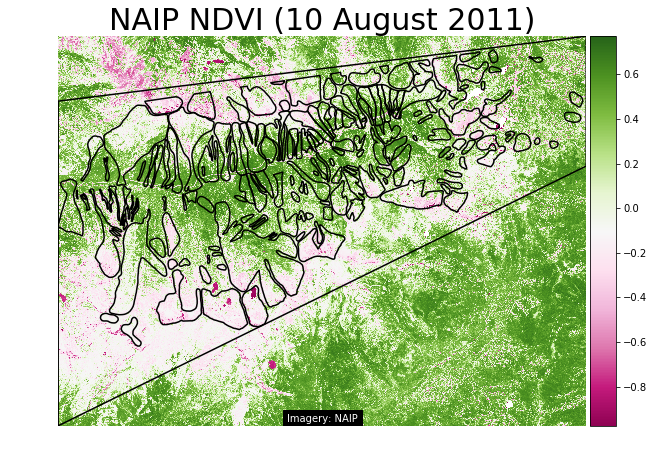

In [5]:
# Plot the 2011 NDVI with the avalanche paths overlaid on top
common.plot_array_and_vector(ndvi_2011_mosaic,
                             mosaic_2011_src.crs,
                             "NAIP NDVI (10 August 2011)",
                             "Imagery: NAIP")
plt.show()

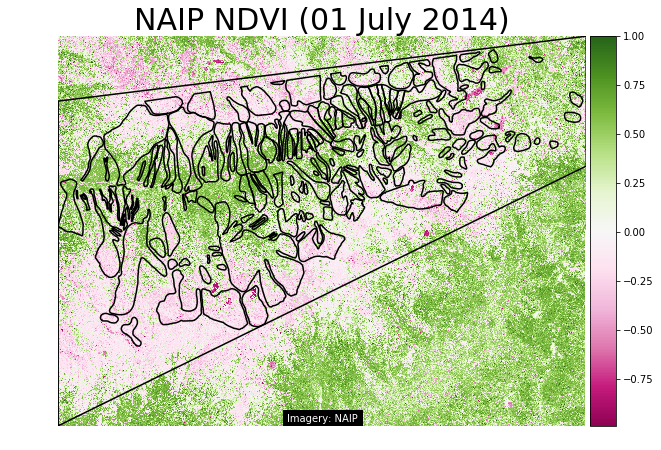

In [6]:
# Plot the 2011 NDVI with the avalanche paths overlaid on top
common.plot_array_and_vector(ndvi_2014_mosaic,
                             mosaic_2014_src.crs,
                             "NAIP NDVI (01 July 2014)",
                             "Imagery: NAIP")
plt.show()

In [7]:
# Open site boundary shapefile
clip_out_path = "data/final-project/cottonwood-heights-utah/vector-clip/utah-avalanche-clip.shp"
avalanche_boundary = gpd.read_file(clip_out_path)

# Open avalanche paths
avalanche_paths_filename = glob(os.path.join(
    'data', 'final-project', 'cottonwood-heights-utah', 'avalanche-paths', '*.shp'))
avalanche_paths = gpd.read_file(avalanche_paths_filename[0])

# Clip paths to site boundary
avalanche_clip = cl.clip_shp(avalanche_paths, avalanche_boundary)

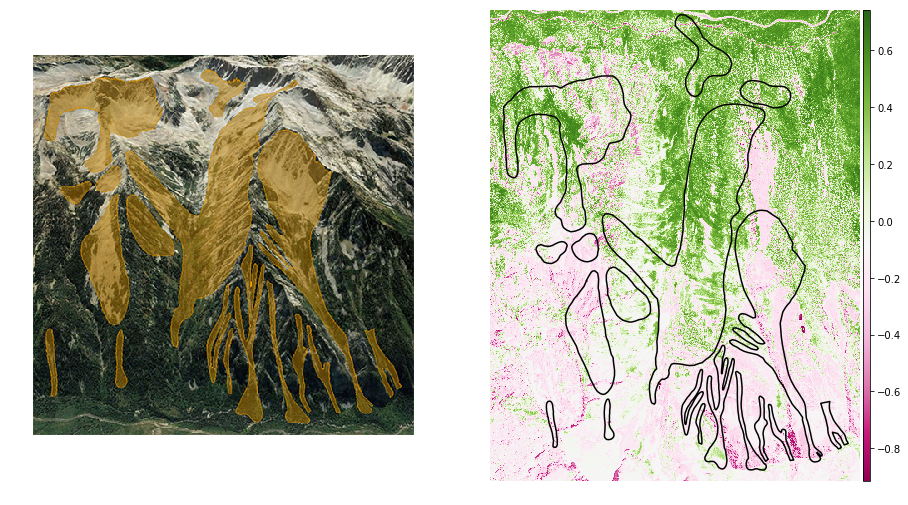

In [8]:
# Plot the Hogum fork NDVI and Google Earth Image
mosaic_2011_fp = "data/final-project/cottonwood-heights-utah/naip/outputs/naip_2011_mosaic_crop.tif"
google_earth_fn = "final-project/avalanche-mapping/images/hogum-fork-avi-path-google-earth.png"
naip.plotHogumFork(mosaic_2011_fp, avalanche_clip, google_earth_fn)
plt.show()

In [9]:
# Compute average NAIP 2011 NDVI within avalanche paths and outside avi paths
avalanche_overlap_shape = common.generate_unioned_avalanche_overlay(mosaic_2011_src.crs)
merged_results_ndvi_2011 = common.rasterstats_grouped_by_height(avalanche_overlap_shape,
                                                                ndvi_2011_mosaic,
                                                                masked_mosaic_2011_affine,
                                                                "mean")

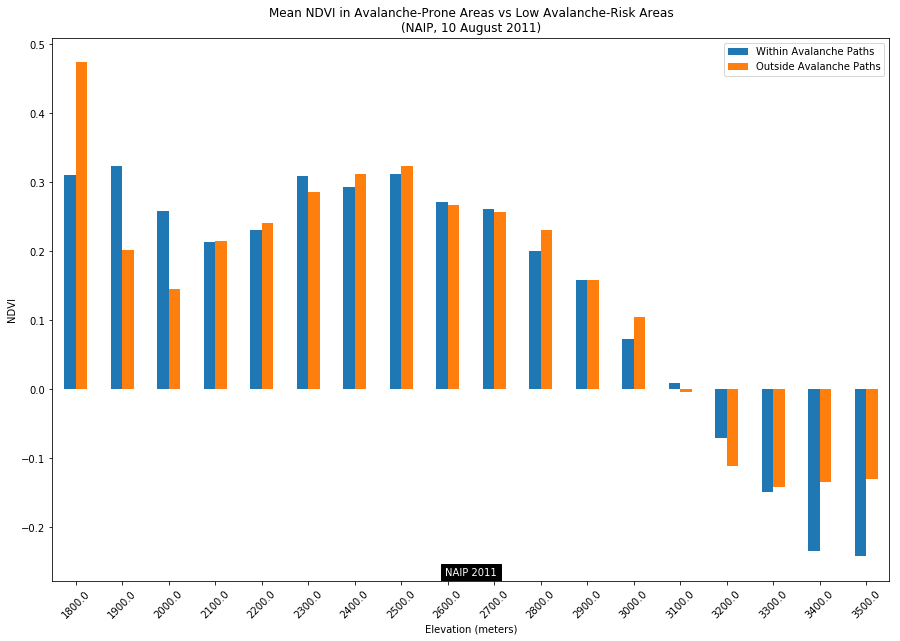

In [10]:
# Plot the average NAIP 2011 NDVI within and outside the avi paths
common.plot_bar(merged_results_ndvi_2011[merged_results_ndvi_2011['height_bucket'] != 0],
                "height_bucket",
                "Elevation (meters)",
                ['mean_avalanche', 'mean_no_avalanche'],
                "NDVI",
                "Mean NDVI in Avalanche-Prone Areas vs Low Avalanche-Risk Areas\n" +
                "(NAIP, 10 August 2011)",
                "NAIP 2011", series_names=['Within Avalanche Paths', 'Outside Avalanche Paths'])
plt.show()

In [11]:
# Compute average NAIP 2014 NDVI within avalanche paths and outside avi paths
avalanche_overlap_shape = common.generate_unioned_avalanche_overlay(mosaic_2014_src.crs)
merged_results_ndvi_2014 = common.rasterstats_grouped_by_height(avalanche_overlap_shape,
                                                                ndvi_2014_mosaic,
                                                                masked_mosaic_2014_affine,
                                                                "mean")

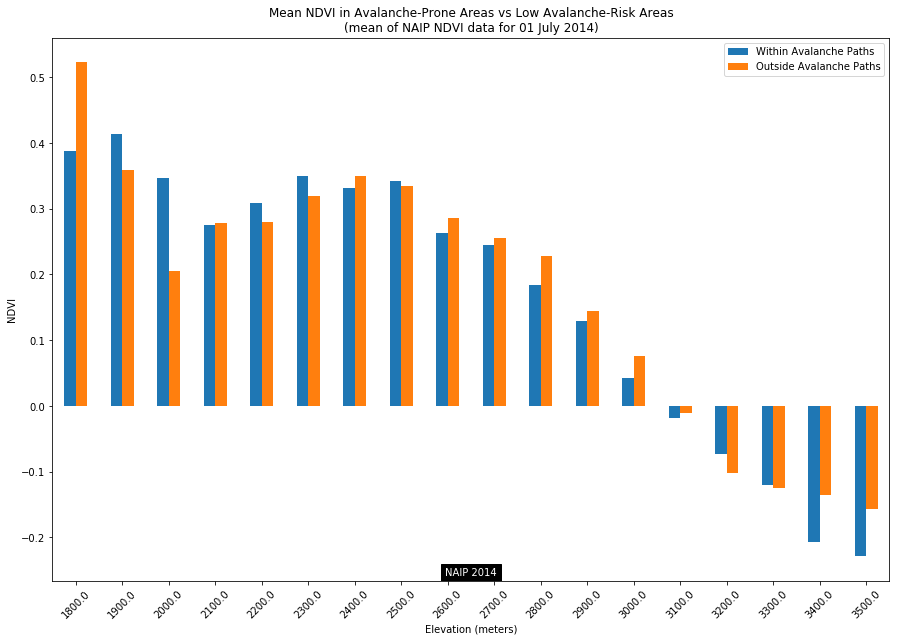

In [12]:
# Plot the average NAIP 2014 NDVI within and outside the avi paths
common.plot_bar(merged_results_ndvi_2014[merged_results_ndvi_2014['height_bucket'] != 0],
                "height_bucket",
                "Elevation (meters)",
                ['mean_avalanche', 'mean_no_avalanche'],
                "NDVI",
                "Mean NDVI in Avalanche-Prone Areas vs Low Avalanche-Risk Areas\n" +
                "(mean of NAIP NDVI data for 01 July 2014)",
                "NAIP 2014", series_names=['Within Avalanche Paths', 'Outside Avalanche Paths'])
plt.show()